# Autoencoders

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

# Setting up

In [2]:
assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def show_image(img):
    img = img.clamp(0, 1) # Ensure that the range of greyscales is between 0 and 1
    npimg = img.numpy()   # Convert to NumPy
    npimg = np.transpose(npimg, (2, 1, 0))
    plt.imshow(npimg)
    plt.show()

We will use the MNIST dataset. First of all, we need to creat the dataset and the data loader:

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2#, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=2
)

# Simple Autoencoder

We will define a simple MLP Autoencoder

In [5]:
class AE(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x            

In [6]:
model = AE(input_size=784).to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

Define the training and testing loops

In [48]:
def train(model, loader, optimizer, criterion, reshape=False):
    loss = 0
    model.train()

    for batch_features, _ in loader:
        batch_features = batch_features.to(device)

        if reshape:
            batch_features = batch_features.view(-1, 784)
        
        optimizer.zero_grad()
        
        outputs = model(batch_features)
        
        train_loss = criterion(outputs, batch_features)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()

    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))

def test(model, loader, criterion, reshape=False):
    loss = 0
    model.eval()
    
    for batch_features, _ in loader:
        batch_features = batch_features.to(device)
        
        if reshape:
            batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs = model(batch_features)
        
        test_loss = criterion(outputs, batch_features)
 
        loss += test_loss.item()
    
    loss = loss / len(loader)
    
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))   

epoch : 1/10, Train loss = 0.049176
epoch : 1/10, Test loss = 0.025515


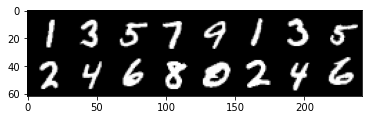

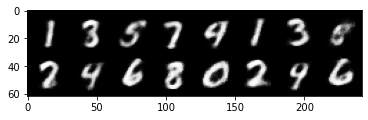

epoch : 2/10, Train loss = 0.020234
epoch : 2/10, Test loss = 0.016447


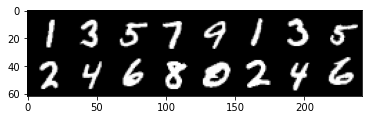

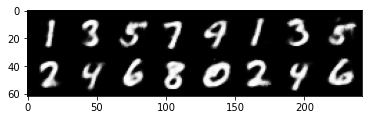

epoch : 3/10, Train loss = 0.014950
epoch : 3/10, Test loss = 0.012734


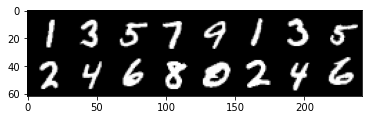

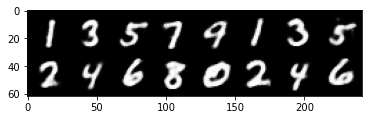

epoch : 4/10, Train loss = 0.012355
epoch : 4/10, Test loss = 0.011154


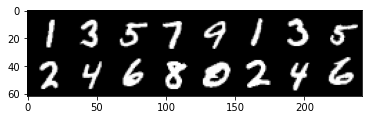

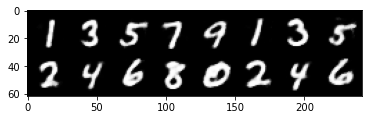

epoch : 5/10, Train loss = 0.010996
epoch : 5/10, Test loss = 0.010003


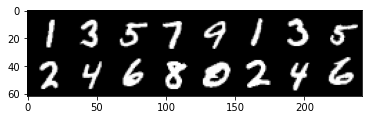

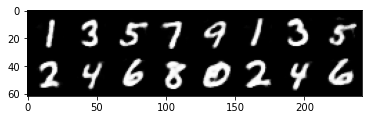

epoch : 6/10, Train loss = 0.009843
epoch : 6/10, Test loss = 0.009110


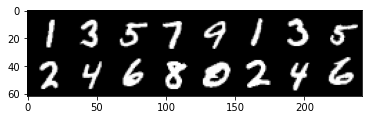

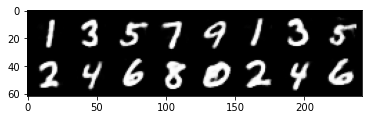

epoch : 7/10, Train loss = 0.008904
epoch : 7/10, Test loss = 0.008247


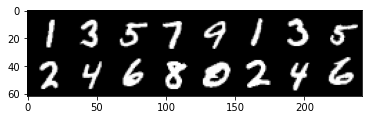

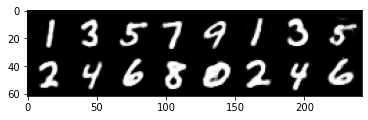

epoch : 8/10, Train loss = 0.008222
epoch : 8/10, Test loss = 0.007652


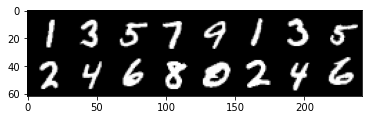

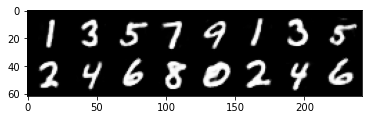

epoch : 9/10, Train loss = 0.007686
epoch : 9/10, Test loss = 0.007201


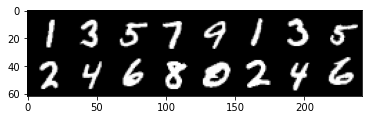

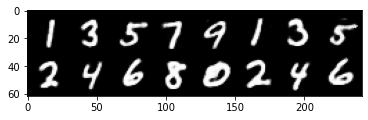

epoch : 10/10, Train loss = 0.007240
epoch : 10/10, Test loss = 0.007031


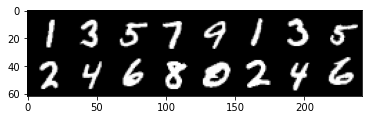

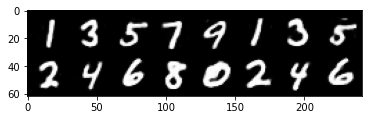

In [8]:
epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion, reshape=True)
    test(model, test_loader, criterion, reshape=True) 

# Convolutional Autoencoder

We will now build a convolutional Autoencoder.

In [10]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2), # b, 16, 5, 5 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1), # b, 8, 15, 15
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1), # b, 1, 28, 28
            nn.Sigmoid()
            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
model = ConvAE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.MSELoss()

epoch : 1/10, Train loss = 0.112742
epoch : 1/10, Test loss = 0.083762


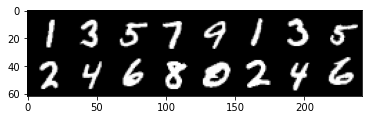

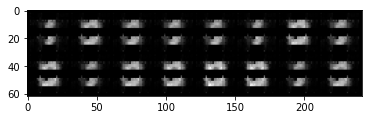

epoch : 2/10, Train loss = 0.065398
epoch : 2/10, Test loss = 0.049864


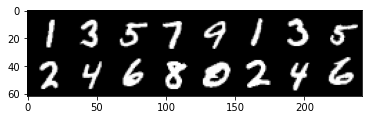

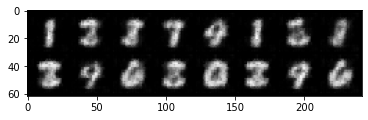

epoch : 3/10, Train loss = 0.045432
epoch : 3/10, Test loss = 0.041787


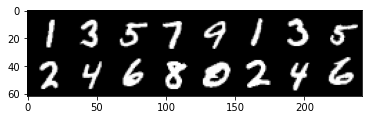

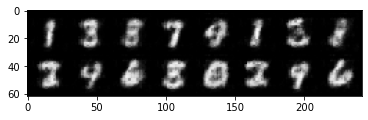

epoch : 4/10, Train loss = 0.040451
epoch : 4/10, Test loss = 0.038498


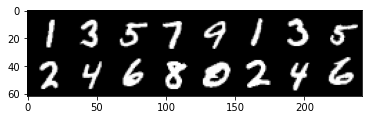

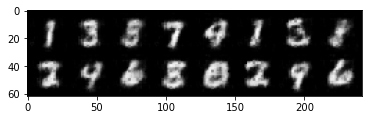

epoch : 5/10, Train loss = 0.037887
epoch : 5/10, Test loss = 0.036360


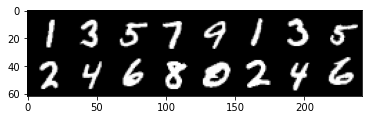

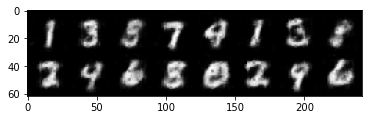

epoch : 6/10, Train loss = 0.036046
epoch : 6/10, Test loss = 0.034604


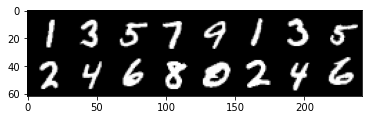

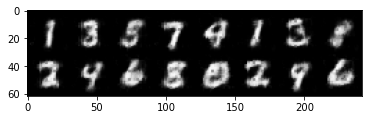

epoch : 7/10, Train loss = 0.034522
epoch : 7/10, Test loss = 0.033297


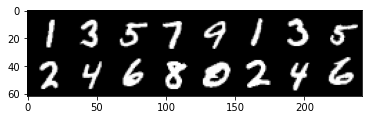

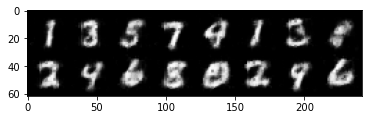

epoch : 8/10, Train loss = 0.033442
epoch : 8/10, Test loss = 0.032375


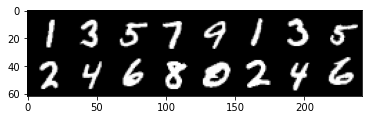

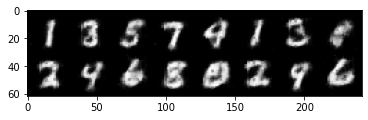

epoch : 9/10, Train loss = 0.032661
epoch : 9/10, Test loss = 0.031674


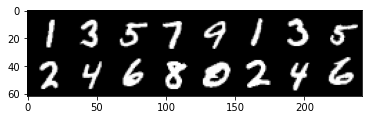

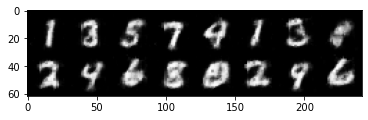

epoch : 10/10, Train loss = 0.032052
epoch : 10/10, Test loss = 0.031131


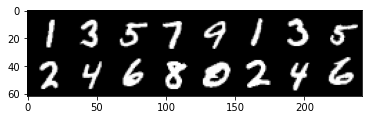

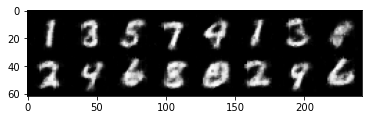

In [12]:
epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion)
    test(model, test_loader, criterion) 

In [13]:
from torchsummary import summary
model1 = AE(input_size=784).to(device)
model2 = ConvAE().to(device)

print(summary(model2, (1, 28, 28)))
print(summary(model1, (784,)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 10, 10]             160
              ReLU-2           [-1, 16, 10, 10]               0
         MaxPool2d-3             [-1, 16, 5, 5]               0
            Conv2d-4              [-1, 8, 3, 3]           1,160
              ReLU-5              [-1, 8, 3, 3]               0
         MaxPool2d-6              [-1, 8, 2, 2]               0
   ConvTranspose2d-7             [-1, 16, 5, 5]           1,168
              ReLU-8             [-1, 16, 5, 5]               0
   ConvTranspose2d-9            [-1, 8, 15, 15]           3,208
             ReLU-10            [-1, 8, 15, 15]               0
  ConvTranspose2d-11            [-1, 1, 28, 28]              33
          Sigmoid-12            [-1, 1, 28, 28]               0
Total params: 5,729
Trainable params: 5,729
Non-trainable params: 0
-----------------------------------

Let's try a new autoencoder, but this time using the MaxUnpool function for the decoder:

In [14]:
class SimetricConvAE(nn.Module):
    def __init__(self):
        super(SimetricConvAE, self).__init__()
        """
        self.conv1 = nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.conv2 = nn.Conv2d(16, 8, 3, stride=2, padding=1)
        
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, stride=1, return_indices=True)
        #nn.ReLU(),
        #nn.MaxPool2d(2, stride=2, return_indices=True),  # b, 16, 5, 5
        #nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
        #nn.ReLU(),
        #nn.MaxPool2d(2, stride=1, return_indices=True)  # b, 8, 2, 2
        """
        # Encode
        self.conv1 = nn.Conv2d(1, 16, 3, stride=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.conv2 = nn.Conv2d(16, 8, 3, stride=2, padding=1)
        self.pool2 = nn.MaxPool2d(2, stride=1, return_indices=True)
            
        
        #Decode
        """
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2), # b, 16, 5, 5
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1), # b, 8, 15, 15
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1), # b, 1, 28, 28
            nn.Sigmoid()
            
        )
        """
            
        self.unpool1 = nn.MaxUnpool2d(2, stride=1)
        self.unconv1 = nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1)
        self.unpool2 = nn.MaxUnpool2d(2, stride=2)
        self.unconv2 = nn.ConvTranspose2d(16, 1, 3, stride=3, padding=1)
        
        
    def encoder(self, x):
        x = torch.relu(self.conv1(x))
        x, self.indices1 = self.pool1(x) #indices son els d'on estan els màxims del max pool
        x = torch.relu(self.conv2(x))
        x, self.indices2 = self.pool2(x)
        
        return x
    
    def decoder(self, x):
        x = self.unpool1(x, self.indices2)
        x = torch.relu(self.unconv1(x))
        x = self.unpool2(x, self.indices1)
        x = torch.sigmoid(self.unconv2(x))
        
        return x
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
model = SimetricConvAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epoch : 1/10, Train loss = 0.170697
epoch : 1/10, Test loss = 0.121848


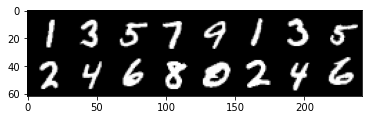

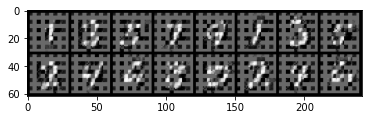

epoch : 2/10, Train loss = 0.102572
epoch : 2/10, Test loss = 0.088283


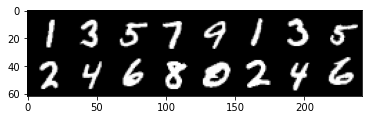

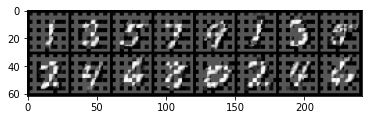

epoch : 3/10, Train loss = 0.077902
epoch : 3/10, Test loss = 0.069542


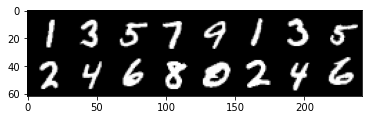

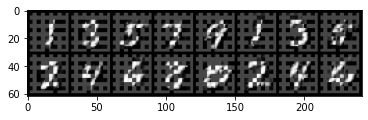

epoch : 4/10, Train loss = 0.063060
epoch : 4/10, Test loss = 0.057923


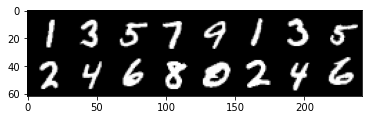

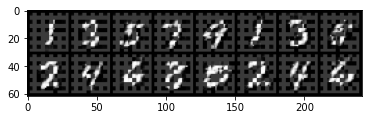

epoch : 5/10, Train loss = 0.053785
epoch : 5/10, Test loss = 0.050577


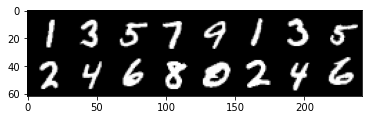

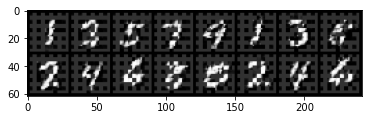

epoch : 6/10, Train loss = 0.047553
epoch : 6/10, Test loss = 0.045348


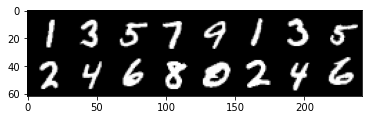

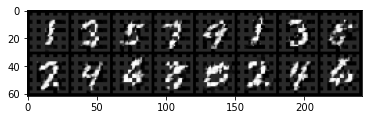

epoch : 7/10, Train loss = 0.043243
epoch : 7/10, Test loss = 0.041860


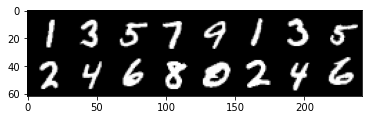

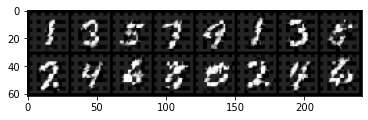

epoch : 8/10, Train loss = 0.039517
epoch : 8/10, Test loss = 0.036843


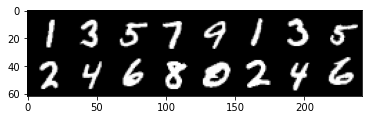

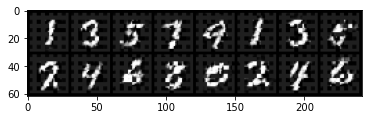

epoch : 9/10, Train loss = 0.034646
epoch : 9/10, Test loss = 0.033331


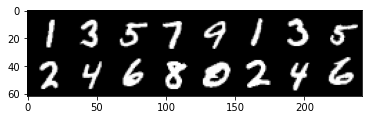

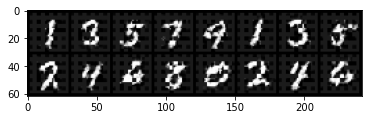

epoch : 10/10, Train loss = 0.032030
epoch : 10/10, Test loss = 0.030918


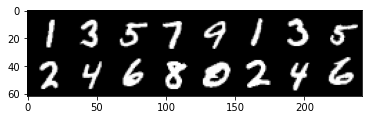

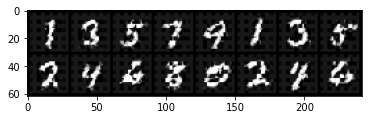

In [16]:
epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion)
    test(model, test_loader, criterion) 

# Variational Autoencoders (VAEs)

In [17]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)

        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [18]:
def loss_function(recon_x, x, mu, logvar):

    recLoss = nn.MSELoss(reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recLoss(recon_x, x) + KLD

In [19]:
model = VAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = loss_function

In [20]:
def train_vae(model, loader, optimizer, criterion):
    loss = 0
    model.train()    
    
    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions as well as the embeddings (we need them for the loss)
        outputs, mu, logvar = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features, mu, logvar)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))


def test_vae(model, loader, criterion):
    loss = 0
    model.eval()
    
    for batch_features, _ in loader:
        batch_features = batch_features.to(device)
        
        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs, mu, logvar = model(batch_features)
        
        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features, mu, logvar)
 
        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()
    
    # compute the epoch test loss
    loss = loss / len(loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    print(batch_features.shape)
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))   

epoch : 1/10, Train loss = 5743.957014
epoch : 1/10, Test loss = 1156.847122
torch.Size([16, 784])


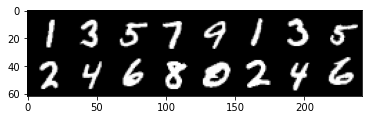

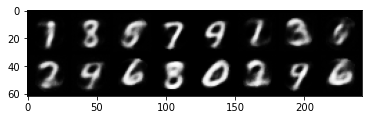

epoch : 2/10, Train loss = 4454.019978
epoch : 2/10, Test loss = 1065.023623
torch.Size([16, 784])


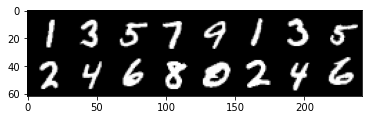

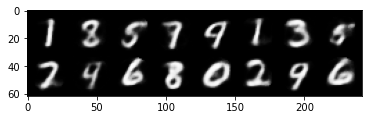

epoch : 3/10, Train loss = 4218.312740
epoch : 3/10, Test loss = 1030.189000
torch.Size([16, 784])


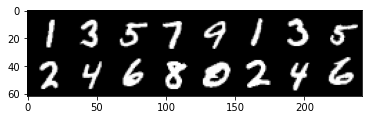

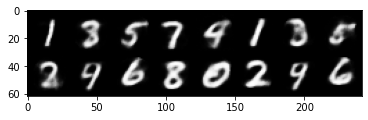

epoch : 4/10, Train loss = 4107.545941
epoch : 4/10, Test loss = 1005.736656
torch.Size([16, 784])


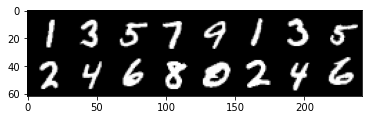

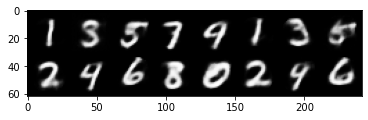

epoch : 5/10, Train loss = 4040.607019
epoch : 5/10, Test loss = 992.773206
torch.Size([16, 784])


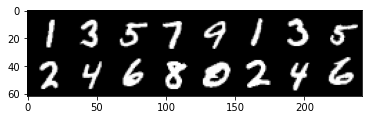

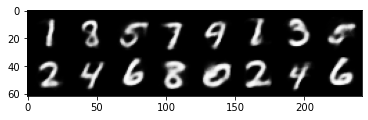

epoch : 6/10, Train loss = 3995.509900
epoch : 6/10, Test loss = 986.671881
torch.Size([16, 784])


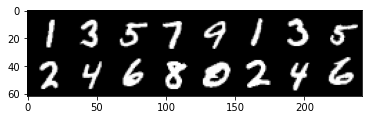

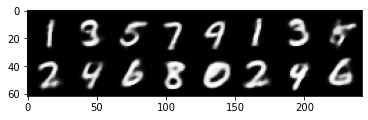

epoch : 7/10, Train loss = 3964.631396
epoch : 7/10, Test loss = 977.545577
torch.Size([16, 784])


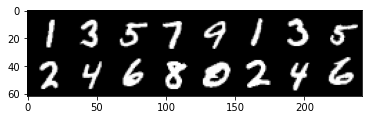

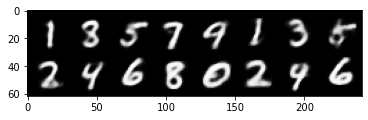

epoch : 8/10, Train loss = 3935.178215
epoch : 8/10, Test loss = 975.548886
torch.Size([16, 784])


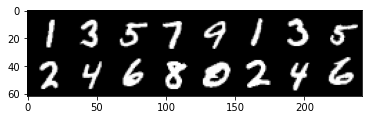

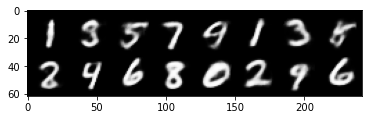

epoch : 9/10, Train loss = 3916.158009
epoch : 9/10, Test loss = 970.221618
torch.Size([16, 784])


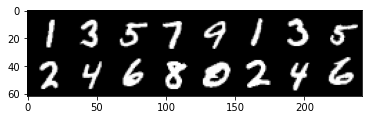

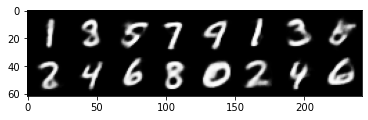

epoch : 10/10, Train loss = 3896.942905
epoch : 10/10, Test loss = 963.223064
torch.Size([16, 784])


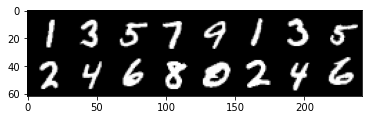

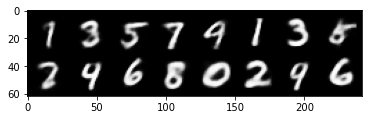

In [21]:
epochs=10
for epoch in range(epochs):
    train_vae(model, train_loader, optimizer, criterion)
    test_vae(model, test_loader, criterion) 

We can now use our variational autoencoder to generate new digits. Below we select two digits, and we interpolate between their embeddings to generate embeddings on the line connecting the two original digits. Then we plot them.

In [22]:
model.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.view(-1, 784).to(device)
        latent_1, _ = model.encode(img1)

        # latent vector of second image
        img2 = img2.view(-1, 784).to(device)
        latent_2, _ = model.encode(img2)

        # interpolation of the two latent vectors
        inter_latent = (1-lambda1) * latent_1 + lambda1 * latent_2

        # reconstruct interpolated image
        inter_image = model.decode(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image


def visualize_interpolation(model, test_dataloader, digit1 = 7, digit2 = 1):   
    # sort part of test set by digit
    digits = [[] for _ in range(10)] # an empty structure to keep samples corresponding to the different digits
    
    for img_batch, label_batch in test_dataloader:
        for i in range(img_batch.size(0)):
            digits[label_batch[i]].append(img_batch[i:i+1])
        if sum(len(d) for d in digits) >= 1000: # stop when we reach 1000 digits
            break;

    # interpolation lambdas
    lambda_range=np.linspace(0,1,10) # Get 10 points between 0 and 1

    fig, axs = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for ind,l in enumerate(lambda_range):
        inter_image=interpolation(float(l), model, digits[digit1][0], digits[digit2][0])
    
        inter_image = inter_image.view(1, 28, 28)
        
        image = inter_image.numpy()
        axs[ind].imshow(image[0,:,:], cmap='gray')
        axs[ind].set_title('lambda_val='+str(round(l,1)))
    plt.show() 

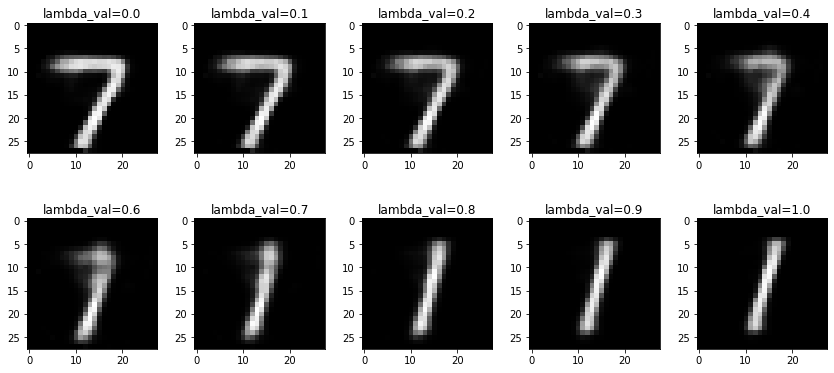

In [23]:
visualize_interpolation(model, test_loader, 7, 1)

Now, using the already trained VAE, we will create 100 new digits:

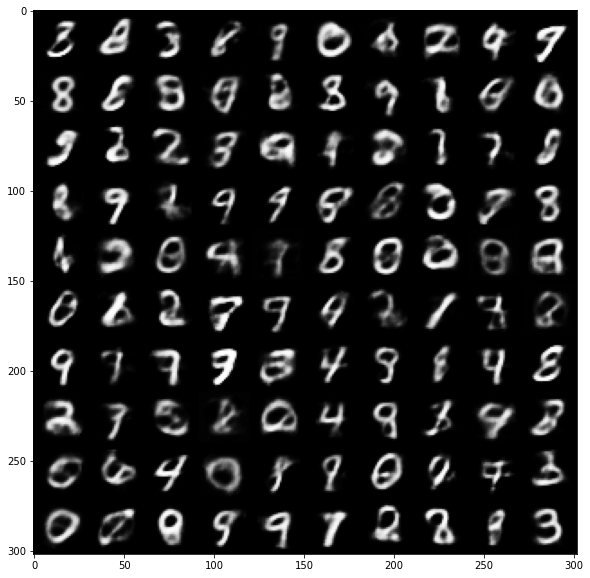

In [36]:
model.eval()

with torch.no_grad():
    randoms = torch.randn(100, 20, device=device)

    images = model.decode(randoms).cpu()
    images = images.view(-1, 1, 28, 28)
    images = images.transpose(2, 3)

    fig, ax = plt.subplots(figsize=(10, 10))    
    show_image(torchvision.utils.make_grid(images.data, nrow = 10))
    plt.show()